# Analysis 1: At What Stages Do Interest Groups Take Positions on a Bill. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import open_csv, save_csv

##### Load report-level bill position & bill status

In [2]:
df = open_csv('analysis_input/analysis1_bill_stage_bill_position_df.csv')

In [3]:
bill_position_color = {         # line color
        'Support': '#01897b',   # green
        'Oppose': '#e6447b',    # pink
        'Amend': '#f7a42f',     # orange
        'Monitor': '#A900FF',   # purple
    }

fill_palette = {                # fill color
        'Support': '#A6E8E1',   # Light green
        'Oppose': '#F2A1A5',    # Light pink
        'Amend': '#F6D3B2',     # Light orange
        'Monitor': '#DABCFF'    # Light purple
    }
    
label_mapping = {
    1: 'Support',
    2: 'Oppose',
    3: 'Amend',
    4: 'Monitor'
}

## Frequency of interest group positions across different legislative stages.

In [4]:
def get_target_final_status_df(bill_status_label_df, final_status, label_mapping, bill_stage_type):
    target_status_df = bill_status_label_df[bill_status_label_df['final_status'].str.contains(final_status, na=False)]
    count_target_status_df = target_status_df.groupby(['label',bill_stage_type]).size().reset_index(name='count')
    count_target_status_df['label'] = count_target_status_df['label'].map(label_mapping)
    return count_target_status_df


def line_plot_bill_stage_bill_position_count(df, target_stages, all_stage_list, selected_stage_lists, bill_stage_type, adjusted_x_interval, save_file_name):
    # Define the desired legend order
    legend_order = [ 'Monitor', 'Support','Amend', 'Oppose']
    
    fig, axes = plt.subplots(len(target_stages), 1, figsize=(9, len(target_stages)*3))
    axes = axes.flatten()

    for i, (ax, target_stage, selected_stages) in enumerate(zip(axes, target_stages, selected_stage_lists)):
        full_x = np.arange(len(all_stage_list))
        
        # simplify detailed bill status name
        target_df = get_target_final_status_df(df, target_stage, label_mapping, bill_stage_type)
        target_df['simple_bill_stage'] = pd.Categorical(target_df['simple_bill_stage'], categories=all_stage_list, ordered=True)

        # add line plot for each final bill status
        for line_idx, label in enumerate(legend_order):
            y = np.full(len(all_stage_list), np.nan)
            label_data = target_df[target_df['label'] == label]
            
            for stage in selected_stages:
                if stage in all_stage_list:
                    stage_idx = all_stage_list.index(stage)
                    count_value = label_data[label_data['simple_bill_stage'] == stage]['count'].values
                    if len(count_value) > 0:
                        y[stage_idx] = count_value[0]
            

            adjusted_full_x = full_x + adjusted_x_interval[:len(full_x)]
            valid_mask = ~np.isnan(y)
            line_color = bill_position_color.get(label, 'black') 

            ax.plot(adjusted_full_x[valid_mask], y[valid_mask], marker='o', markersize=4, 
                    linestyle='-', label=f'{label}', color=line_color)

            highlight_start_idx = None
            highlight_end_idx = None

            # add bill status index
            if label in ['Support', 'Monitor'] and 'ENACTED_AFTER' in selected_stages:
                highlight_start_idx = all_stage_list.index('PASSED')
                highlight_end_idx = all_stage_list.index('ENACTED_AFTER')

            if label in ['Oppose', 'Amend'] and 'VETOED_AFTER' in selected_stages:
                highlight_start_idx = all_stage_list.index('PASS_OVER')
                highlight_end_idx = all_stage_list.index('VETOED_AFTER')

            if label in ['Oppose', 'Amend'] and 'PASSED_AFTER' in selected_stages:
                highlight_start_idx = all_stage_list.index('PASS_OVER')
                highlight_end_idx = all_stage_list.index('PASSED_AFTER')

            if label in ['Oppose', 'Amend'] and 'PROV_KILL_AFTER' in selected_stages:
                highlight_start_idx = all_stage_list.index('PASS_OVER')
                highlight_end_idx = all_stage_list.index('PROV_KILL_AFTER')
                
            if highlight_start_idx is not None and highlight_end_idx is not None:
                segment_mask = np.zeros_like(valid_mask, dtype=bool)
                segment_mask[highlight_start_idx:highlight_end_idx + 1] = True
                segment_mask = segment_mask & valid_mask
                
                ax.plot(adjusted_full_x[segment_mask], y[segment_mask], marker='o', markersize=5, 
                        linestyle='-', color=line_color, linewidth=3)

            # fill color for line plot
            fill_color = fill_palette.get(label, 'gray')
            ax.fill_between(adjusted_full_x[valid_mask], y[valid_mask], color=fill_color, alpha=0.3)


        ax.set_title(f'{target_stage_name_list[i]}',  fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.3)
        
        ax.set_xticks(adjusted_full_x)
        ax.set_xticklabels([all_stage_name_list[i] if stage in selected_stages else '' for i, stage in enumerate(all_stage_list)],
                   rotation=0, ha='center', fontsize=11.5)
        ax.tick_params(axis='x', which='both', length=0)
        ax.tick_params(axis='y', labelsize=11)  
        
        x_labels = all_stage_list
        y_min, y_max = ax.get_ylim()
        padding = 1.6
        ax.set_ylim(y_min - y_max * 0.05, y_max * padding)
        
        ax.set_xlim(-1, len(all_stage_list)+0.3)
        ax.set_ylabel('Lobbying Count',  labelpad=10, fontsize=12) # 
        
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
            order = [1, 3, 2, 0]
            sorted_handles = [handles[i] for i in order]
            sorted_labels = [labels[i] for i in order]



        annotation_fontsize = 12
        if 'REFERRED' in selected_stages and 'REPORTED' in selected_stages:
            start_x = adjusted_full_x[x_labels.index('REFERRED')]
            end_x = adjusted_full_x[x_labels.index('REPORTED')]
            mid_x = (start_x + end_x) / 2  # Midpoint for center text
            ax.annotate('', xy=(start_x, y_max * 1.15), xytext=(end_x, y_max * 1.15),
                        arrowprops=dict(arrowstyle='<->', color='black', lw=1))
            ax.text(mid_x, y_max * 1.25, 'Committee', ha='center', color='black', fontsize=annotation_fontsize) # 
            ax.vlines(start_x, y_min - y_max * 0.05, y_max * 1.7, colors='gray', linestyles='--', linewidth=0.8)
            ax.vlines(end_x, y_min - y_max * 0.05, y_max * 1.7, colors='gray', linestyles='--', linewidth=0.8)
        
        if 'REPORTED' in selected_stages and 'PASSED' in selected_stages:
            start_x = adjusted_full_x[x_labels.index('REPORTED')]
            end_x = adjusted_full_x[x_labels.index('PASSED')]
            mid_x = (start_x + end_x) / 2  # Midpoint for center text
            ax.annotate('', xy=(start_x, y_max * 1.15), xytext=(end_x, y_max * 1.15),
                        arrowprops=dict(arrowstyle='<->', color='black', lw=1))
            ax.text(mid_x, y_max * 1.25, 'Floor Debate', ha='center', color='black', fontsize=annotation_fontsize) # 
            ax.vlines(start_x, y_min - y_max * 0.05, y_max * 1.7, colors='gray', linestyles='--', linewidth=0.8)
            ax.vlines(end_x, y_min - y_max * 0.05, y_max * 1.7, colors='gray', linestyles='--', linewidth=0.8)
        
        if 'PASSED' in selected_stages and 'ENACTED' in selected_stages:
            start_x = adjusted_full_x[x_labels.index('PASSED')]
            end_x = adjusted_full_x[x_labels.index('ENACTED')]
            mid_x = (start_x + end_x) / 2  # Midpoint for center text
            ax.annotate('', xy=(start_x, y_max * 1.15), xytext=(end_x, y_max * 1.15),
                        arrowprops=dict(arrowstyle='<->', color='black', lw=1))
            ax.text(mid_x, y_max * 1.25, 'Presidential Action', ha='center', color='black', fontsize=annotation_fontsize) # 
            ax.vlines(start_x, y_min - y_max * 0.05, y_max * 1.7, colors='gray', linestyles='--', linewidth=0.8)
            ax.vlines(end_x, y_min - y_max * 0.05, y_max * 1.7, colors='gray', linestyles='--', linewidth=0.8)



    handles, labels = axes[0].get_legend_handles_labels()

    desired_order = ['Support', 'Oppose', 'Amend', 'Monitor']
    
    ordered_handles = [handles[labels.index(label)] for label in desired_order if label in labels]
    ordered_labels = [label for label in desired_order if label in labels]
    
    fig.legend(
        ordered_handles, 
        ordered_labels, 
        fontsize=14, 
        title_fontsize=12, 
        loc='lower center',
        bbox_to_anchor=(0.5, -0.06),
        ncol=4,
        frameon=True
    )

    plt.tight_layout()
    os.makedirs('result', exist_ok=True)
    plt.savefig(f'analysis_output/analysis1_{save_file_name}.pdf', bbox_inches='tight', format='pdf')
    plt.show()


## Fig. 2. Frequency of interest group positions across different legislative stages.

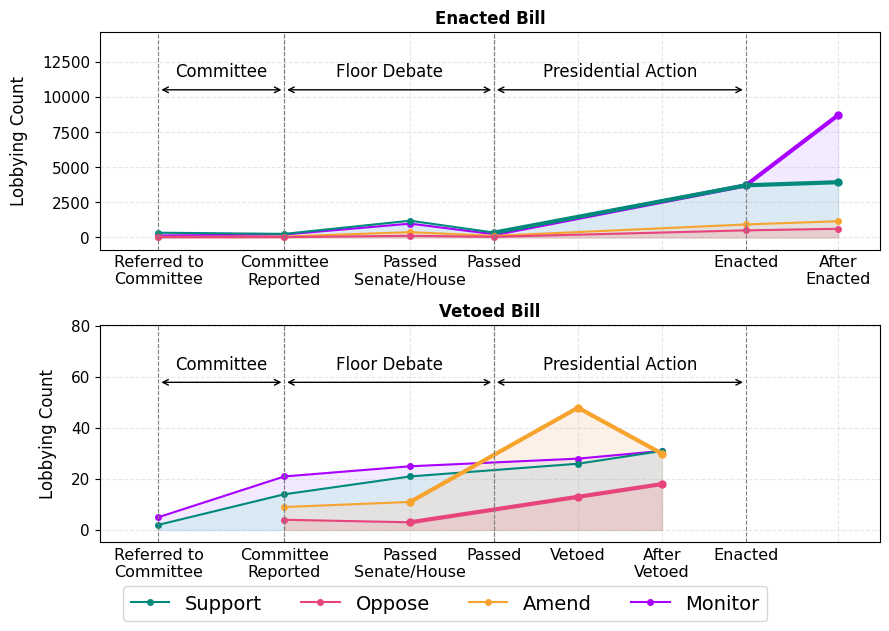

In [5]:
all_stage_list = ['REFERRED', 'REPORTED', 'PASS_OVER', 
                  'PASSED', 'VETOED', 'VETOED_AFTER', 'ENACTED', 'ENACTED_AFTER']
all_stage_name_list = ['Referred to\nCommittee','Committee\nReported','Passed\nSenate/House', \
                      'Passed', 'Vetoed', 'After\nVetoed',\
                       'Enacted', 'After\nEnacted']

target_stages = ['ENACTED','VETOED']
target_stage_name_list = ['Enacted Bill','Vetoed Bill']
adjusted_x_interval = [-0.3, 0.2, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8]
save_file_name = 'fig2'

selected_stage_lists = [
    ['REFERRED', 'REPORTED', 'PASS_OVER', 'PASSED', 'ENACTED', 'ENACTED_AFTER'],
    ['REFERRED', 'REPORTED', 'PASS_OVER', 'PASSED', 'VETOED', 'VETOED_AFTER', 'ENACTED'],]

line_plot_bill_stage_bill_position_count(df, target_stages, all_stage_list, selected_stage_lists, 'simple_bill_stage', adjusted_x_interval, save_file_name)



## Fig. 8. Frequency of interest group positions across different legislative stages in ’Passed’ and ’Provisionally Killed’ bills. (in SI Appendix)

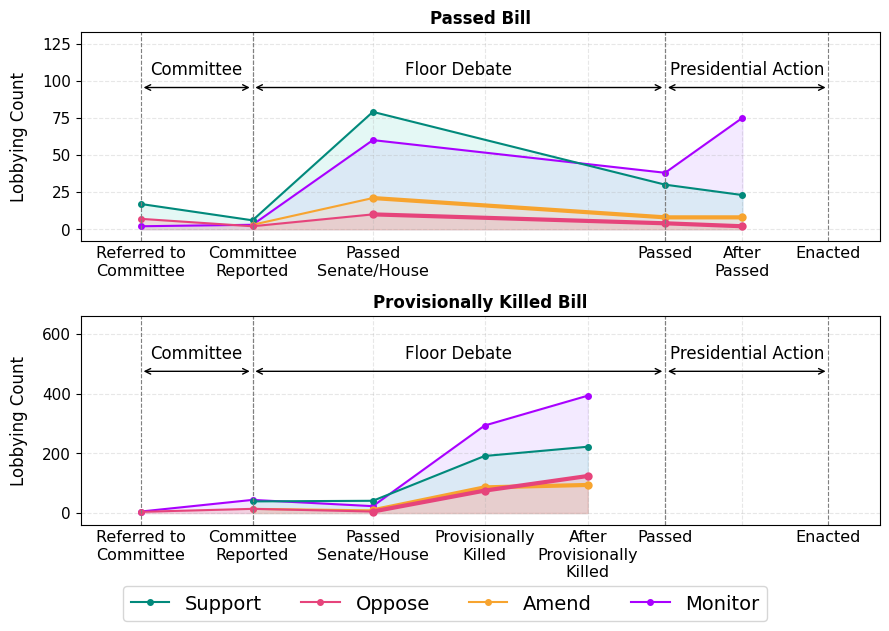

In [6]:
all_stage_list = ['REFERRED', 'REPORTED', 'PASS_OVER', 'PROV_KILL', 'PROV_KILL_AFTER',
                  'PASSED', 'PASSED_AFTER', 'ENACTED']
all_stage_name_list = ['Referred to\nCommittee','Committee\nReported','Passed\nSenate/House', \
                       'Provisionally\nKilled', 'After\nProvisionally\nKilled', 'Passed', 'After\nPassed', \
                       'Enacted']

target_stages = ['PASSED', 'PROV_KILL']
target_stage_name_list = ['Passed Bill', 'Provisionally Killed Bill']
adjusted_x_interval = [-0.3, 0, 0.4, 0.7, 0.9, 0.8, 0.7, 0.7, 0.7, 0.7, 0.5]
save_file_name = 'fig8_appendix'


selected_stage_lists = [
    ['REFERRED', 'REPORTED', 'PASS_OVER', 'PASSED', 'PASSED_AFTER', 'ENACTED'],
    ['REFERRED', 'REPORTED', 'PASS_OVER', 'PROV_KILL', 'PROV_KILL_AFTER', 'PASSED', 'ENACTED']
]

line_plot_bill_stage_bill_position_count(df, target_stages, all_stage_list, selected_stage_lists, 'simple_bill_stage', adjusted_x_interval, save_file_name)

